# Relationship Classification — Analysis

This notebook is split into two phases:

- **Part 1 — Pre-training** (cells up to "Part 2"): dataset statistics, class balance, text characteristics, co-occurrence. Run these **before** training to understand your data.
- **Part 2 — Post-training** (everything after): grid search heatmaps, test metrics, confusion matrices, error analysis. Run these **after** `train.ipynb` (or `python train.py`) has completed.

Post-training cells gracefully skip if no results exist yet.

---
## Setup

In [19]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from training.config import (
    DATASET_PATH,
    DATASET_SHEET,
    EVAL_CSV,
    GRID_SEARCH_CSV,
    LABEL_TRUE_VALUES,
    LABELS,
    PREDICTIONS_SUBDIR,
    RESULTS_DIR,
    TEXT_COLUMN,
)

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid", palette="muted")
pd.set_option("display.max_colwidth", 120)

%matplotlib inline

---
## Load Dataset

In [20]:
ext = os.path.splitext(DATASET_PATH)[1].lower()
if ext == ".xlsx":
    df = pd.read_excel(DATASET_PATH, sheet_name=DATASET_SHEET)
else:
    df = pd.read_csv(DATASET_PATH)

for label in LABELS:
    df[label] = df[label].apply(lambda v: v in LABEL_TRUE_VALUES)

df = df.dropna(subset=[TEXT_COLUMN]).reset_index(drop=True)
df["text_len"] = df[TEXT_COLUMN].str.len()
df["word_count"] = df[TEXT_COLUMN].str.split().str.len()
df["n_labels"] = df[LABELS].sum(axis=1).astype(int)

print(f"Dataset: {len(df):,} rows, {len(df.columns)} columns")
df.head(3)

Dataset: 50 rows, 10 columns


,text,romantic,family,friendship,professional,unknown,irrelevant,text_len,word_count,n_labels
0,She kissed him softly on the forehead before they fell asleep together.,True,False,False,False,False,False,71,12,1
1,My mother called me every Sunday without fail for twenty years.,False,True,False,False,False,False,63,11,1
2,We've been best friends since third grade and still talk every day.,False,False,True,False,False,False,67,12,1


---
## Load Results (if available)

In [21]:
eval_path = os.path.join(RESULTS_DIR, EVAL_CSV)
grid_path = os.path.join(RESULTS_DIR, GRID_SEARCH_CSV)

HAS_RESULTS = os.path.isfile(eval_path)

if HAS_RESULTS:
    full_eval_df = pd.read_csv(eval_path)
    eval_df = full_eval_df[full_eval_df["stage"] == "optimized"].reset_index(drop=True)
    baseline_df = full_eval_df[full_eval_df["stage"] == "baseline"].reset_index(drop=True)
    HAS_BASELINE = len(baseline_df) > 0
    grid_df = pd.read_csv(grid_path) if os.path.isfile(grid_path) else None

    preds, baseline_preds = {}, {}
    for label in LABELS:
        for stage, store in [("optimized", preds), ("baseline", baseline_preds)]:
            p = os.path.join(RESULTS_DIR, PREDICTIONS_SUBDIR, f"{stage}_{label}_predictions.csv")
            if os.path.isfile(p):
                store[label] = pd.read_csv(p)

    print(f"Results loaded: {len(eval_df)} optimized, {len(baseline_df)} baseline.")
    if grid_df is not None:
        print(f"Grid search: {len(grid_df)} trials.")
else:
    grid_df = eval_df = baseline_df = None
    HAS_BASELINE = False
    preds, baseline_preds = {}, {}
    print("No results found — post-training sections will be skipped.")
    print("Run `python train.py` first, then re-run this notebook.")

No results found — post-training sections will be skipped.
Run `python train.py` first, then re-run this notebook.


---
---
# Part 1: Pre-Training Analysis

Run these cells **before** training to understand the dataset.

---
## Global Overview

### Label Distribution

              count   pct
family           11  22.0
professional     11  22.0
romantic         10  20.0
friendship       10  20.0
unknown           5  10.0
irrelevant        5  10.0


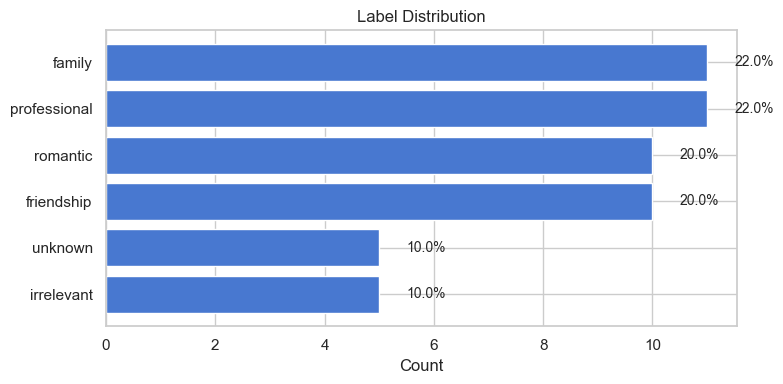

In [22]:
counts = df[LABELS].sum().sort_values(ascending=False)
pcts = (counts / len(df) * 100).round(1)

summary = pd.DataFrame({"count": counts, "pct": pcts})
print(summary.to_string())

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.barh(counts.index[::-1], counts.values[::-1])
for bar, pct in zip(bars, pcts.values[::-1]):
    ax.text(
        bar.get_width() + len(df) * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{pct}%",
        va="center",
        fontsize=10,
    )
ax.set_xlabel("Count")
ax.set_title("Label Distribution")
plt.tight_layout()
plt.show()

Unique texts: 50 | Multi-label: 2 (4.0%)


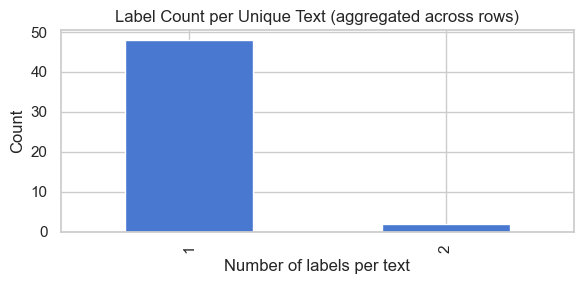

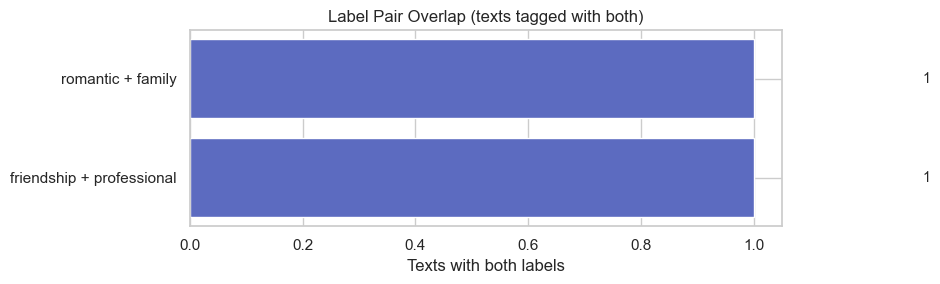

In [23]:
# Aggregate labels across rows sharing the same text
df_agg = df.groupby(TEXT_COLUMN)[LABELS].any().reset_index()
df_agg["n_labels"] = df_agg[LABELS].sum(axis=1).astype(int)

n_unique = len(df_agg)
n_multi = (df_agg["n_labels"] > 1).sum()
print(f"Unique texts: {n_unique} | Multi-label: {n_multi} ({n_multi / n_unique * 100:.1f}%)")

# Labels per unique text
fig, ax = plt.subplots(figsize=(6, 3))
df_agg["n_labels"].value_counts().sort_index().plot.bar(ax=ax)
ax.set_xlabel("Number of labels per text")
ax.set_ylabel("Count")
ax.set_title("Label Count per Unique Text (aggregated across rows)")
plt.tight_layout()
plt.show()

# Label pair co-occurrence (sorted bar chart)
from itertools import combinations

pair_counts = {}
for l1, l2 in combinations(LABELS, 2):
    count = int((df_agg[l1] & df_agg[l2]).sum())
    if count > 0:
        pair_counts[f"{l1} + {l2}"] = count

if pair_counts:
    pairs_sorted = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)
    pair_labels, pair_values = zip(*pairs_sorted)

    fig, ax = plt.subplots(figsize=(10, max(3, len(pair_labels) * 0.4)))
    bars = ax.barh(pair_labels[::-1], pair_values[::-1], color="#5C6BC0")
    for bar in bars:
        w = bar.get_width()
        ax.text(w + 0.3, bar.get_y() + bar.get_height() / 2,
                str(int(w)), va="center", fontsize=10)
    ax.set_xlabel("Texts with both labels")
    ax.set_title("Label Pair Overlap (texts tagged with both)")
    plt.tight_layout()
    plt.show()
else:
    print("No label co-occurrences found.")

### Text Length Overview

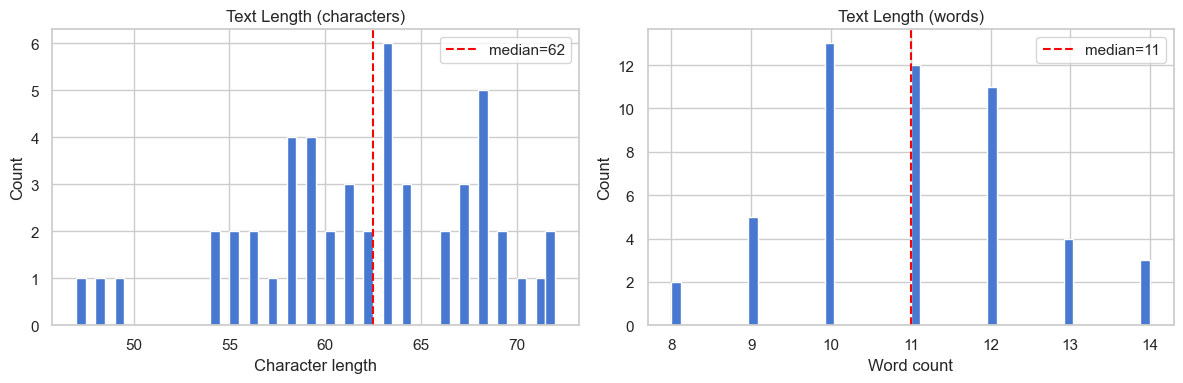

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df["text_len"].hist(bins=50, ax=axes[0], edgecolor="white")
axes[0].set_xlabel("Character length")
axes[0].set_ylabel("Count")
axes[0].set_title("Text Length (characters)")
axes[0].axvline(
    df["text_len"].median(),
    color="red",
    linestyle="--",
    label=f"median={df['text_len'].median():.0f}",
)
axes[0].legend()

df["word_count"].hist(bins=50, ax=axes[1], edgecolor="white")
axes[1].set_xlabel("Word count")
axes[1].set_ylabel("Count")
axes[1].set_title("Text Length (words)")
axes[1].axvline(
    df["word_count"].median(),
    color="red",
    linestyle="--",
    label=f"median={df['word_count'].median():.0f}",
)
axes[1].legend()

plt.tight_layout()
plt.show()

### DSPy Split Summary

In [ ]:
from training.data import split_pipeline
from loguru import logger

logger.disable("training")
splits = split_pipeline.run(df)
logger.enable("training")

rows = []
for label in LABELS:
    ls = splits[label]
    rows.append({
        "label": label,
        "train_pos": int(ls.dspy.train[label].sum()),
        "train_neg": int((~ls.dspy.train[label]).sum()),
        "val_pos": int(ls.dspy.val[label].sum()),
        "val_neg": int((~ls.dspy.val[label]).sum()),
        "holdout_pos": int(ls.holdout[label].sum()),
        "holdout_neg": int((~ls.holdout[label]).sum()),
    })

split_df = pd.DataFrame(rows)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(split_df))
w = 0.25

# Positives
for i, (col, lbl, color) in enumerate([
    ("train_pos", "Train", "#2196F3"),
    ("val_pos", "Val", "#FF9800"),
    ("holdout_pos", "Holdout", "#4CAF50"),
]):
    offset = (i - 1) * w
    rects = axes[0].bar(x + offset, split_df[col], w, label=lbl, color=color)
    for rect in rects:
        h = rect.get_height()
        if h > 0:
            axes[0].text(rect.get_x() + rect.get_width() / 2, h + 0.3,
                         str(int(h)), ha="center", va="bottom", fontsize=9)

axes[0].set_xticks(x)
axes[0].set_xticklabels(split_df["label"], rotation=45, ha="right")
axes[0].set_ylabel("Count")
axes[0].set_title("Positive Examples per Split")
axes[0].legend()

# Negatives
for i, (col, lbl, color) in enumerate([
    ("train_neg", "Train", "#2196F3"),
    ("val_neg", "Val", "#FF9800"),
    ("holdout_neg", "Holdout", "#4CAF50"),
]):
    offset = (i - 1) * w
    rects = axes[1].bar(x + offset, split_df[col], w, label=lbl, color=color)
    for rect in rects:
        h = rect.get_height()
        if h > 0:
            axes[1].text(rect.get_x() + rect.get_width() / 2, h + 0.3,
                         str(int(h)), ha="center", va="bottom", fontsize=9)

axes[1].set_xticks(x)
axes[1].set_xticklabels(split_df["label"], rotation=45, ha="right")
axes[1].set_ylabel("Count")
axes[1].set_title("Negative Examples per Split")
axes[1].legend()

plt.suptitle("DSPy Splits per Label (deterministic — matches training)", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

---
---
# Part 2: Post-Training Analysis

Run these cells **after** training has completed (`train.ipynb` or `python train.py`).
Results are loaded from `training/results/`.

---
### Global Holdout Results Summary

In [ ]:
if HAS_RESULTS and eval_df is not None:
    display_cols = [
        c
        for c in [
            "label",
            "holdout_f1",
            "holdout_precision",
            "holdout_recall",
            "holdout_accuracy",
            "n_holdout",
            "n_holdout_positive",
            "gen_model",
            "reflection_model",
        ]
        if c in eval_df.columns
    ]
    print("=== Optimised Results ===")
    display(eval_df[display_cols])

    if HAS_BASELINE and baseline_df is not None:
        baseline_cols = [
            c
            for c in ["label", "holdout_f1", "holdout_precision", "holdout_recall", "holdout_accuracy", "gen_model"]
            if c in baseline_df.columns
        ]
        print("\n=== Baseline Results ===")
        display(baseline_df[baseline_cols])

        # Side-by-side comparison with P/R/F1
        comparison = eval_df[["label", "holdout_f1", "holdout_precision", "holdout_recall"]].copy()
        comparison = comparison.rename(columns={
            "holdout_f1": "opt_f1", "holdout_precision": "opt_P", "holdout_recall": "opt_R"
        })
        bl = baseline_df[["label", "holdout_f1", "holdout_precision", "holdout_recall"]].copy()
        bl = bl.rename(columns={
            "holdout_f1": "base_f1", "holdout_precision": "base_P", "holdout_recall": "base_R"
        })
        comparison = comparison.merge(bl, on="label", how="outer")
        comparison["f1_delta"] = comparison["opt_f1"] - comparison["base_f1"]
        print("\n=== Baseline vs Optimised ===")
        display(comparison[["label", "base_f1", "base_P", "base_R", "opt_f1", "opt_P", "opt_R", "f1_delta"]])

        # Grouped bar chart (F1 only — more bars would be unreadable)
        fig, ax = plt.subplots(figsize=(10, 5))
        x = np.arange(len(comparison))
        w = 0.35
        ax.bar(x - w / 2, comparison["base_f1"], w, label="Baseline F1")
        ax.bar(x + w / 2, comparison["opt_f1"], w, label="Optimised F1")
        ax.set_xticks(x)
        ax.set_xticklabels(comparison["label"], rotation=45, ha="right")
        ax.set_ylabel("F1 Score")
        ax.set_title("Baseline vs Optimised — Holdout F1 by Label")
        ax.set_ylim(0, 1.05)
        ax.legend()
        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(8, 4))
        metrics = eval_df.set_index("label")[["holdout_f1", "holdout_precision", "holdout_recall"]]
        metrics.plot.bar(ax=ax)
        ax.set_ylabel("Score")
        ax.set_title("Holdout Metrics by Label")
        ax.set_ylim(0, 1.05)
        ax.legend(loc="lower right")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
else:
    print("Skipped — no results.")

---
## Per-Label Deep Dive

Each label below has two cells:
1. **Pre-training** — class balance, text length by class, sample examples. Safe to run anytime.
2. **Post-training** — grid search heatmap, test confusion matrix, error examples. Requires training results.

In [ ]:
def pre_training_analysis(label):
    """Pre-training statistics for a single label."""
    pos = df[df[label]]
    neg = df[~df[label]]
    n_pos, n_neg = len(pos), len(neg)
    print(
        f"Positive: {n_pos} ({n_pos / len(df) * 100:.1f}%)  |  "
        f"Negative: {n_neg} ({n_neg / len(df) * 100:.1f}%)"
    )
    print(f"Imbalance ratio: 1:{n_neg / n_pos:.1f}" if n_pos > 0 else "No positives!")
    print()

    # Text length comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))
    for ax, col, title in [
        (axes[0], "text_len", "Char length"),
        (axes[1], "word_count", "Word count"),
    ]:
        bins = np.linspace(df[col].min(), df[col].quantile(0.95), 40)
        ax.hist(neg[col], bins=bins, alpha=0.6, label="Negative", edgecolor="white")
        ax.hist(pos[col], bins=bins, alpha=0.6, label="Positive", edgecolor="white")
        ax.set_xlabel(title)
        ax.set_ylabel("Count")
        ax.legend()
        ax.set_title(f"{title} — positive vs negative")
    plt.suptitle(f"'{label}' — text length distributions", fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

    # Co-occurring labels (using aggregated data)
    agg_pos = df_agg[df_agg[label]]
    if len(agg_pos) > 0:
        other_labels = [lb for lb in LABELS if lb != label]
        co_counts = agg_pos[other_labels].sum().sort_values(ascending=False)
        co_pcts = (co_counts / len(agg_pos) * 100).round(1)
        has_co = co_counts.sum() > 0
        if has_co:
            print("Co-occurring labels among positive texts:")
            for name, count in co_counts.items():
                if count > 0:
                    print(f"  {name}: {int(count)} ({co_pcts[name]}%)")
        else:
            print("No co-occurring labels.")
        print()

    # Sample examples
    n_show = min(3, n_pos)
    if n_show > 0:
        print(f"Sample positive examples (n={n_show}):")
        for _, row in pos.sample(n=n_show, random_state=42).iterrows():
            print(f"  - {row[TEXT_COLUMN][:200]}")
    print()


def post_training_analysis(label):
    """Post-training results for a single label."""
    if not HAS_RESULTS or eval_df is None:
        print("Skipped — no results.")
        return

    # Grid search heatmap
    if grid_df is not None and label in grid_df["label"].values:
        label_grid = grid_df[grid_df["label"] == label]
        metric_col = "holdout_f1" if "holdout_f1" in label_grid.columns else "val_f1"
        pivot = label_grid.pivot_table(
            index="gen_model", columns="reflection_model", values=metric_col
        )
        fig, ax = plt.subplots(figsize=(7, 4))
        sns.heatmap(
            pivot,
            annot=True,
            fmt=".3f",
            cmap="YlOrRd",
            ax=ax,
            vmin=0,
            vmax=1,
            square=True,
        )
        ax.set_title(f"'{label}' — Grid Search {metric_col.replace('_', ' ').title()}")
        plt.tight_layout()
        plt.show()

    # Baseline vs Optimised metrics
    row = eval_df[eval_df["label"] == label]
    if row.empty:
        print(f"No evaluation row for '{label}'.")
        return
    row = row.iloc[0]

    if HAS_BASELINE and baseline_df is not None:
        bl_row = baseline_df[baseline_df["label"] == label]
        if not bl_row.empty:
            bl_row = bl_row.iloc[0]
            print(f"{'Metric':<12} {'Baseline':>10} {'Optimised':>10}")
            print(f"{'-'*12} {'-'*10} {'-'*10}")
            print(f"{'F1':<12} {bl_row['holdout_f1']:>10.4f} {row['holdout_f1']:>10.4f}")
            print(f"{'Precision':<12} {bl_row['holdout_precision']:>10.4f} {row['holdout_precision']:>10.4f}")
            print(f"{'Recall':<12} {bl_row['holdout_recall']:>10.4f} {row['holdout_recall']:>10.4f}")
            print(f"{'Accuracy':<12} {bl_row['holdout_accuracy']:>10.4f} {row['holdout_accuracy']:>10.4f}")
            print()
    else:
        print(f"F1:        {row['holdout_f1']:.4f}")
        print(f"Precision: {row['holdout_precision']:.4f}")
        print(f"Recall:    {row['holdout_recall']:.4f}")
        print(f"Accuracy:  {row['holdout_accuracy']:.4f}")
        print()

    print(
        f"Holdout size: {int(row['n_holdout'])} ({int(row['n_holdout_positive'])} positive)"
    )
    if "gen_model" in row.index:
        print(f"Generation model:  {row['gen_model']}")
        print(f"Reflection model:  {row['reflection_model']}")
    print()

    # Confusion matrix
    if label in preds:
        pred_df = preds[label]
        y_true = (pred_df["gold"] == "true").astype(int)
        y_pred = (pred_df["predicted"] == "true").astype(int)
        cm = confusion_matrix(y_true, y_pred)

        fig, ax = plt.subplots(figsize=(4, 4))
        ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot(
            ax=ax, cmap="Blues"
        )
        ax.set_title(f"'{label}' — Holdout Confusion Matrix")
        plt.tight_layout()
        plt.show()

        # Error examples
        errors = pred_df[~pred_df["correct"]]
        if len(errors) > 0:
            fn = errors[errors["gold"] == "true"]
            fp = errors[errors["predicted"] == "true"]
            print(f"Errors: {len(errors)} total — {len(fp)} FP, {len(fn)} FN")
            for err_type, err_df in [("False Positive", fp), ("False Negative", fn)]:
                n_show = min(3, len(err_df))
                if n_show > 0:
                    print(f"\n  {err_type} examples (n={n_show}):")
                    for _, r in err_df.head(n_show).iterrows():
                        print(f"    - {r['text'][:200]}")
        else:
            print("No errors on the holdout set!")
    print()

---
### romantic

In [ ]:
print("=" * 60)
print("PRE-TRAINING — romantic")
print("=" * 60)
pre_training_analysis("romantic")

In [ ]:
print("=" * 60)
print("POST-TRAINING — romantic")
print("=" * 60)
post_training_analysis("romantic")

---
### family

In [ ]:
print("=" * 60)
print("PRE-TRAINING — family")
print("=" * 60)
pre_training_analysis("family")

In [ ]:
print("=" * 60)
print("POST-TRAINING — family")
print("=" * 60)
post_training_analysis("family")

---
### friendship

In [ ]:
print("=" * 60)
print("PRE-TRAINING — friendship")
print("=" * 60)
pre_training_analysis("friendship")

In [ ]:
print("=" * 60)
print("POST-TRAINING — friendship")
print("=" * 60)
post_training_analysis("friendship")

---
### professional

In [ ]:
print("=" * 60)
print("PRE-TRAINING — professional")
print("=" * 60)
pre_training_analysis("professional")

In [ ]:
print("=" * 60)
print("POST-TRAINING — professional")
print("=" * 60)
post_training_analysis("professional")

---
### unknown

In [ ]:
print("=" * 60)
print("PRE-TRAINING — unknown")
print("=" * 60)
pre_training_analysis("unknown")

In [ ]:
print("=" * 60)
print("POST-TRAINING — unknown")
print("=" * 60)
post_training_analysis("unknown")

---
### irrelevant

In [ ]:
print("=" * 60)
print("PRE-TRAINING — irrelevant")
print("=" * 60)
pre_training_analysis("irrelevant")

In [ ]:
print("=" * 60)
print("POST-TRAINING — irrelevant")
print("=" * 60)
post_training_analysis("irrelevant")